#Install libraries

In [749]:
pip install yfinance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [750]:
pip install pandas_ta

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


#Classification On Stocks based on Closing Price Derivatives

##Calculate features

In [751]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import yfinance as yf  
yf.pdr_override()
from pandas_datareader import data as pdr
import pandas_ta as pta
from sklearn.preprocessing import MinMaxScaler, StandardScaler 
from tensorflow.keras.layers import Dense, LSTM,GRU,SimpleRNN, Dropout,Bidirectional
from tensorflow.keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import Dense, LSTM

In [829]:
df = pdr.get_data_yahoo("TCS.NS", start="1980-02-01", end="2022-07-13")

[*********************100%***********************]  1 of 1 completed


In [830]:
df_close = df
df_close

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2002-08-12,38.724998,40.000000,38.724998,39.700001,28.485003,212976
2002-08-13,39.750000,40.387501,38.875000,39.162498,28.099335,153576
2002-08-14,39.250000,39.250000,35.724998,36.462502,26.162066,822776
2002-08-15,36.462502,36.462502,36.462502,36.462502,26.162066,0
2002-08-16,36.275002,38.000000,35.750000,36.375000,26.099283,811856
...,...,...,...,...,...,...
2022-07-06,3218.500000,3268.500000,3202.250000,3260.750000,3179.367188,2182144
2022-07-07,3271.000000,3319.399902,3265.050049,3287.850098,3205.791016,1989921
2022-07-08,3300.000000,3305.000000,3250.000000,3265.449951,3183.949707,2136916


In [831]:
df_close['EWMA15'] = df_close['Close'].ewm(span=5).mean()
df_close['EWMA15_pct'] = df_close['EWMA15'].pct_change()*100
# df_close['EWMA20'] = df_close['Close'].ewm(span=20).mean()
# df_close['EWMA50'] = df_close['Close'].ewm(span=50).mean()
df_close['RSI7'] = pta.rsi(df['Close'], length = 7)
df_close['RSI7_pct'] = df_close['RSI7'].pct_change()*100
# df_close['RSI14'] = pta.rsi(df['Close'], length = 14)
# df_close['RSI20'] = pta.rsi(df['Close'], length = 20)

# delta = df_close['Close'].diff(1)
# delta = delta.dropna()
# up = delta.copy()
# down = delta.copy()
# up[up<0] = 0
# down[down>0] = down
# df_close['up'] = up
# df_close['down'] = down

#Intraday difference
df_close['diff'] = ((df_close['Close'] - df_close['Open'])/df_close['Open'])*100

df_close['target'] = np.where(df_close['Open'].shift(-1)>df_close['Close'], 1, 0)


In [832]:
#Create target to determine if tomorrow's price would be greater than today's price
#Interday difference

In [833]:
df_close

,Open,High,Low,Close,Adj Close,Volume,EWMA15,EWMA15_pct,RSI7,RSI7_pct,diff,target
Date,,,,,,,,,,,,
2002-08-12,38.724998,40.000000,38.724998,39.700001,28.485003,212976,39.700001,NaN,NaN,NaN,2.517759,1
2002-08-13,39.750000,40.387501,38.875000,39.162498,28.099335,153576,39.377499,-0.812346,NaN,NaN,-1.477991,1
2002-08-14,39.250000,39.250000,35.724998,36.462502,26.162066,822776,37.996711,-3.506542,NaN,NaN,-7.101907,0
2002-08-15,36.462502,36.462502,36.462502,36.462502,26.162066,0,37.359424,-1.677216,NaN,NaN,0.000000,0
2002-08-16,36.275002,38.000000,35.750000,36.375000,26.099283,811856,36.981517,-1.011543,NaN,NaN,0.275668,1
...,...,...,...,...,...,...,...,...,...,...,...,...
2022-07-06,3218.500000,3268.500000,3202.250000,3260.750000,3179.367188,2182144,3256.515419,0.065059,49.427750,23.980195,1.312723,1
2022-07-07,3271.000000,3319.399902,3265.050049,3287.850098,3205.791016,1989921,3266.960312,0.320738,54.565721,10.394912,0.515136,1
2022-07-08,3300.000000,3305.000000,3250.000000,3265.449951,3183.949707,2136916,3266.456858,-0.015410,49.696781,-8.923075,-1.046971,0


##Create Dataset, Scale and create Training and Testing Split

In [853]:
buffer_df = df_close[['EWMA15_pct', 'diff']]
target_df = df_close['target']

In [854]:
df_combined = buffer_df[8:]
target_df = target_df[8:]

In [855]:
df_combined

,EWMA15_pct,diff
Date,,
2002-08-22,2.613451,0.980704
2002-08-23,3.800743,5.093166
2002-08-26,2.277248,-1.919714
2002-08-27,0.596513,-3.294121
2002-08-28,0.423696,0.396589
...,...,...
2022-07-06,0.065059,1.312723
2022-07-07,0.320738,0.515136
2022-07-08,-0.015410,-1.046971


In [856]:
import math

#Split the data

training_data_len = math.ceil( len(df_combined) *.8)
df_for_training = df_combined.iloc[:training_data_len,:]
target_for_training = target_df.iloc[:training_data_len]
df_for_testing = df_combined.iloc[training_data_len:,:]
target_for_testing = target_df.iloc[training_data_len:]

#Scale the data
scaler = StandardScaler()
scaler = scaler.fit(df_for_training)
df_combined_training_scaled = scaler.transform(df_for_training)
df_combined_training_scaled = pd.DataFrame(df_combined_training_scaled)


In [857]:
trainX = []
trainY = []  
n_future = 1  # Number of days we want to predict into the future

n_past = 30 
for i in range(n_past, len(df_combined_training_scaled)):
     trainX.append(df_combined_training_scaled.iloc[i - n_past:i, 0:df_for_training.shape[1]])
     trainY.append(target_for_training.iloc[i])

trainX, trainY = np.array(trainX), np.array(trainY)
print(trainX.shape, trainY.shape)

(3923, 30, 2) (3923,)


In [858]:
from keras import Model
from keras.layers import Layer
from keras.layers import Input, Dense
import keras.backend as K

class attention(Layer):
    def __init__(self,**kwargs):
        super(attention,self).__init__(**kwargs)

    def build(self,input_shape):
        self.W=self.add_weight(name='attention_weight', shape=(input_shape[-1],1), 
                               initializer='random_normal', trainable=True)
        self.b=self.add_weight(name='attention_bias', shape=(input_shape[1],1), 
                               initializer='zeros', trainable=True)        
        super(attention, self).build(input_shape)

    def call(self,x):
        # Alignment scores. Pass them through tanh function
        e = K.tanh(K.dot(x,self.W)+self.b)
        # Remove dimension of size 1
        e = K.squeeze(e, axis=-1)   
        # Compute the weights
        alpha = K.softmax(e)
        # Reshape to tensorFlow format
        alpha = K.expand_dims(alpha, axis=-1)
        # Compute the context vector
        context = x * alpha
        context = K.sum(context, axis=1)
        return context

In [ ]:
import keras

def create_LSTM_with_attention(hidden_units, dense_units):
    x=Input(shape=(trainX.shape[1:]))
    conv_x = keras.layers.Conv1D(30, 3, activation='relu')(x)
    attention_layer = attention()(conv_x)
    print(attention_layer.shape, attention_layer)
    dropout_lstm = keras.layers.Dropout(.2)(attention_layer)
    reshaped_attention = keras.layers.Reshape((30,1), input_shape=(30,))(dropout_lstm)
    batchnorm_reshaped_attention = keras.layers.BatchNormalization()(reshaped_attention)
    lstm_layer = LSTM(100, return_sequences=True, activation='relu')(batchnorm_reshaped_attention)
    lstm_layer = LSTM(50, return_sequences=False, activation='relu')(lstm_layer)
    outputs=Dense(1, trainable=True, activation='sigmoid')(lstm_layer)
    model=Model(x,outputs)
    model.compile(loss='binary_crossentropy', optimizer='adam')    
    return model    

# Create the model with attention, train and evaluate
model_attention = create_LSTM_with_attention(hidden_units=100, dense_units=1)

model_attention.summary()    

model_attention.fit(trainX, trainY, epochs=10, batch_size=32, verbose=2, validation_split=0.2)

In [860]:
# def create_LSTM_with_attention(hidden_units, dense_units):
#     x=Input(shape=(trainX.shape[1:]))
#     lstm_layer = LSTM(hidden_units, return_sequences=True, activation='relu')(x)
#     attention_layer = attention()(lstm_layer)
#     outputs=Dense(1, trainable=True, activation='sigmoid')(attention_layer)
#     model=Model(x,outputs)
#     model.compile(loss='binary_crossentropy', optimizer='adam')    
#     return model    

# # Create the model with attention, train and evaluate
# model_attention = create_LSTM_with_attention(hidden_units=100, dense_units=1)

# model_attention.summary()    

# history = model_attention.fit(trainX, trainY, epochs=20, batch_size=32, verbose=2, validation_split=0.2)

In [861]:
df_combined_testing_scaled = scaler.transform(df_for_testing)
df_combined_testing_scaled = pd.DataFrame(df_combined_testing_scaled)

testX = []
testY = []  
n_future = 1  # Number of days we want to predict into the future

n_past = 30 
for i in range(n_past, len(df_combined_testing_scaled)):
     testX.append(df_combined_testing_scaled.iloc[i - n_past:i, 0:df_for_testing.shape[1]])
     testY.append(target_for_training.iloc[i])

testX, testY = np.array(testX), np.array(testY)
print(testX.shape, testY.shape)

(958, 30, 2) (958,)


30/30 [==============================] - 1s 22ms/step


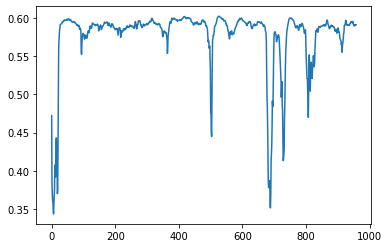

In [862]:
import matplotlib.pyplot as plt

preds = model_attention.predict(testX)
plt1 = plt.plot(preds)

In [883]:
new_preds = []
for i in range(0, len(preds)):
    if preds[i]>0.5:
      new_preds.append(1)
      new_preds.append(1)

In [ ]:
# from sklearn.metrics import confusion_matrix, accuracy_score

# print(accuracy_score(new_preds, testY))
# print(confusion_matrix(new_preds, testY))

In [885]:
final_buffer_df = pd.merge(df_for_testing, df_close[['Open', 'Close']], left_index=True, right_index=True)
final_df = final_buffer_df[30:]
final_df.reset_index(drop = True, inplace = True)

In [886]:
new_preds_df = pd.DataFrame(new_preds)
final_df['target'] = new_preds_df

<ipython-input-886-2af81055eebc>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_df['target'] = new_preds_df


In [887]:
final_df

,EWMA15_pct,diff,Open,Close,target
0,0.415860,0.388189,2035.099976,2043.000000,1
1,0.406053,0.386681,2043.000000,2050.899902,1
2,0.569444,0.690995,2055.000000,2069.199951,1
3,0.423098,-0.024125,2072.500000,2072.000000,1
4,0.449595,0.696320,2068.000000,2082.399902,1
...,...,...,...,...,...
953,0.065059,1.312723,3218.500000,3260.750000,1
954,0.320738,0.515136,3271.000000,3287.850098,1
955,-0.015410,-1.046971,3300.000000,3265.449951,1
956,-1.557823,-2.880397,3206.149902,3113.800049,1


In [888]:
unique, counts = np.unique(testY, return_counts=True)
dict(zip(unique, counts))

{0: 493, 1: 465}

In [889]:
final_df['target'].value_counts()

1    958
Name: target, dtype: int64

In [890]:
profit = 0
loss = 0

for i in range(0, final_df.shape[0]-1):
    signal = final_df['target'][i]
    next_day_open = final_df['Open'][i+1]
    today_close = final_df['Close'][i]
    percent_change = (next_day_open- today_close)*100/today_close
    if signal == 0 and percent_change < 0:
      profit += abs(percent_change)
    elif signal == 0 and percent_change > 0:
      loss += abs(percent_change)
    elif signal ==1 and percent_change >0:
      profit += abs(percent_change)
    elif signal == 1 and percent_change <0:
      loss += abs(percent_change)


In [891]:
profit, loss

(319.93290682241815, 196.80222161230108)

In [882]:
final_df['target'].shape

(958,)

In [827]:
# #Wrapper function to create all combinations
# import math

# final_df_shape = []
# profit_arr = []
# cf_matrix = []
# acc_scores = []
# def master_fn():
#   df = pdr.get_data_yahoo("TCS.NS", start="1980-02-01", end="2022-07-13")
#   df_close = df
#   df_close['EWMA15'] = df_close['Close'].ewm(span=5).mean()
#   df_close['EWMA15_pct'] = df_close['EWMA15'].pct_change()*100
#   df_close['RSI7'] = pta.rsi(df['Close'], length = 7)
#   df_close['RSI7_pct'] = df_close['RSI7'].pct_change()*100
#   df_close['diff'] = ((df_close['Close'] - df_close['Open'])/df_close['Open'])*100
#   df_close['target'] = np.where(df_close['Open'].shift(-1)>df_close['Close'], 1, 0)
#   target_df = df_close['target']

#   feature_list = [['diff', 'RSI7_pct'], ['diff', 'EWMA15_pct'], ['EWMA15_pct', 'RSI7_pct']]
#   for count, features in enumerate(feature_list):
#     print(count, features)
#     buffer_df = df_close[features]
#     df_combined = buffer_df[10:]
#     target_df = target_df[10:]

#     #Split the data

#     training_data_len = math.ceil( len(df_combined) *.8)
#     df_for_training = df_combined.iloc[:training_data_len,:]
#     target_for_training = target_df.iloc[:training_data_len]
#     df_for_testing = df_combined.iloc[training_data_len:,:]
#     target_for_testing = target_df.iloc[training_data_len:]

#     #Scale the data
#     scaler = StandardScaler()
#     scaler = scaler.fit(df_for_training)
#     df_combined_training_scaled = scaler.transform(df_for_training)
#     df_combined_training_scaled = pd.DataFrame(df_combined_training_scaled)
#     trainX = []
#     trainY = []  
#     n_future = 1  # Number of days we want to predict into the future

#     n_past = 30 
#     for i in range(n_past, len(df_combined_training_scaled)):
#         trainX.append(df_combined_training_scaled.iloc[i - n_past:i, 0:df_for_training.shape[1]])
#         trainY.append(target_for_training.iloc[i])

#     trainX, trainY = np.array(trainX), np.array(trainY)
#     print(trainX.shape, trainY.shape)

#     model_attention = create_LSTM_with_attention(hidden_units=100, dense_units=1)

#     model_attention.fit(trainX, trainY, epochs=10, batch_size=32, verbose=2, validation_split=0.2)

#     df_combined_testing_scaled = scaler.transform(df_for_testing)
#     df_combined_testing_scaled = pd.DataFrame(df_combined_testing_scaled)

#     testX = []
#     testY = []  
#     n_future = 1  # Number of days we want to predict into the future

#     n_past = 30 
#     for i in range(n_past, len(df_combined_testing_scaled)):
#         testX.append(df_combined_testing_scaled.iloc[i - n_past:i, 0:df_for_testing.shape[1]])
#         testY.append(target_for_training.iloc[i])

#     testX, testY = np.array(testX), np.array(testY)
#     print(testX.shape, testY.shape)

#     preds = model_attention.predict(testX)

#     new_preds = []
#     for i in range(0, len(preds)):
#         if preds[i]>0.5:
#           new_preds.append(1)
#         else:
#           new_preds.append(0)

#     acc_scores.append(accuracy_score(new_preds, testY))
#     cf_matrix.append(confusion_matrix(new_preds, testY))
#     print(confusion_matrix(new_preds, testY))
#     final_buffer_df = pd.merge(df_for_testing, df_close[['Open', 'Close']], left_index=True, right_index=True)
#     final_df = final_buffer_df[30:]
#     final_df.reset_index(drop = True, inplace = True)

#     new_preds_df = pd.DataFrame(new_preds)
#     final_df['target'] = new_preds_df
#     profit = 0
#     loss = 0

#     for i in range(0, final_df.shape[0]-1):
#         signal = final_df['target'][i]
#         next_day_open = final_df['Open'][i+1]
#         today_close = final_df['Close'][i]
#         percent_change = (next_day_open- today_close)*100/today_close
#         if signal == 0 and percent_change < 0:
#           profit += abs(percent_change)
#         elif signal == 0 and percent_change > 0:
#           loss += abs(percent_change)
#         elif signal ==1 and percent_change >0:
#           profit += abs(percent_change)
#         elif signal == 1 and percent_change <0:
#           loss += abs(percent_change)
#     print("profit is: ", profit-loss)
#     profit_arr.append(profit-loss)
    
# master_fn()

[*********************100%***********************]  1 of 1 completed
0 ['diff', 'RSI7_pct']
(3922, 30, 2) (3922,)
(None, 30) KerasTensor(type_spec=TensorSpec(shape=(None, 30), dtype=tf.float32, name=None), name='attention_49/Sum:0', description="created by layer 'attention_49'")
Epoch 1/10
99/99 - 8s - loss: 0.6290 - val_loss: 0.6818 - 8s/epoch - 86ms/step
Epoch 2/10
99/99 - 4s - loss: 0.7285 - val_loss: 0.6819 - 4s/epoch - 43ms/step
Epoch 3/10
99/99 - 5s - loss: 0.6675 - val_loss: 0.6830 - 5s/epoch - 48ms/step
Epoch 4/10
99/99 - 4s - loss: 0.6459 - val_loss: 0.6843 - 4s/epoch - 40ms/step
Epoch 5/10
99/99 - 4s - loss: 0.6418 - val_loss: 0.6842 - 4s/epoch - 44ms/step
Epoch 6/10
99/99 - 5s - loss: 0.6630 - val_loss: 0.6834 - 5s/epoch - 47ms/step
Epoch 7/10
99/99 - 4s - loss: 0.6441 - val_loss: 0.6858 - 4s/epoch - 40ms/step
Epoch 8/10
99/99 - 4s - loss: 0.6186 - val_loss: 0.6850 - 4s/epoch - 45ms/step
Epoch 9/10
99/99 - 5s - loss: 0.6156 - val_loss: 0.6837 - 5s/epoch - 46ms/step
Epoch 10/

<ipython-input-827-d2c041f2f386>:87: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_df['target'] = new_preds_df


(3922, 30, 2) (3922,)
(None, 30) KerasTensor(type_spec=TensorSpec(shape=(None, 30), dtype=tf.float32, name=None), name='attention_50/Sum:0', description="created by layer 'attention_50'")
Epoch 1/10
99/99 - 9s - loss: 0.6528 - val_loss: 0.6808 - 9s/epoch - 93ms/step
Epoch 2/10
99/99 - 6s - loss: 0.6314 - val_loss: 0.6819 - 6s/epoch - 57ms/step
Epoch 3/10
99/99 - 5s - loss: 0.6289 - val_loss: 0.6808 - 5s/epoch - 47ms/step
Epoch 4/10
99/99 - 6s - loss: 0.6238 - val_loss: 0.6810 - 6s/epoch - 57ms/step
Epoch 5/10
99/99 - 5s - loss: 0.6243 - val_loss: 0.6828 - 5s/epoch - 46ms/step
Epoch 6/10
99/99 - 5s - loss: 0.6225 - val_loss: 0.6874 - 5s/epoch - 48ms/step
Epoch 7/10
99/99 - 6s - loss: 0.6241 - val_loss: 0.6814 - 6s/epoch - 57ms/step
Epoch 8/10
99/99 - 5s - loss: 0.6240 - val_loss: 0.6826 - 5s/epoch - 46ms/step
Epoch 9/10
99/99 - 6s - loss: 0.6231 - val_loss: 0.6833 - 6s/epoch - 57ms/step
Epoch 10/10
99/99 - 5s - loss: 0.6234 - val_loss: 0.6982 - 5s/epoch - 46ms/step
(957, 30, 2) (957,)
3

<ipython-input-827-d2c041f2f386>:87: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_df['target'] = new_preds_df


(3922, 30, 2) (3922,)
(None, 30) KerasTensor(type_spec=TensorSpec(shape=(None, 30), dtype=tf.float32, name=None), name='attention_51/Sum:0', description="created by layer 'attention_51'")
Epoch 1/10
99/99 - 9s - loss: 0.6547 - val_loss: 0.6806 - 9s/epoch - 95ms/step
Epoch 2/10
99/99 - 4s - loss: 0.6341 - val_loss: 0.6805 - 4s/epoch - 40ms/step
Epoch 3/10
99/99 - 5s - loss: 0.6520 - val_loss: 0.6807 - 5s/epoch - 51ms/step
Epoch 4/10
99/99 - 4s - loss: 0.6426 - val_loss: 0.6812 - 4s/epoch - 43ms/step
Epoch 5/10
99/99 - 4s - loss: 0.6304 - val_loss: 0.6815 - 4s/epoch - 41ms/step
Epoch 6/10
99/99 - 5s - loss: 0.6268 - val_loss: 0.6830 - 5s/epoch - 53ms/step
Epoch 7/10
99/99 - 4s - loss: 0.6258 - val_loss: 0.6807 - 4s/epoch - 40ms/step
Epoch 8/10
99/99 - 4s - loss: 0.6268 - val_loss: 0.6806 - 4s/epoch - 41ms/step
Epoch 9/10
99/99 - 5s - loss: 0.6265 - val_loss: 0.6819 - 5s/epoch - 52ms/step
Epoch 10/10
99/99 - 4s - loss: 0.6256 - val_loss: 0.6822 - 4s/epoch - 42ms/step
(957, 30, 2) (957,)
3

<ipython-input-827-d2c041f2f386>:87: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_df['target'] = new_preds_df


In [828]:
for i in cf_matrix:
  print(i)

[[  0   0]
 [493 464]]
[[ 23  51]
 [472 411]]
[[  2   2]
 [494 459]]


In [826]:
final_df

,diff,RSI7_pct,Open,Close,target
0,-2.039924,-35.944953,1252.500000,1226.949951,1
1,0.620928,8.147709,1228.000000,1235.625000,1
2,-0.325807,-5.342903,1235.400024,1231.375000,1
3,0.481777,9.639421,1235.000000,1240.949951,1
4,-0.370966,-7.687083,1240.000000,1235.400024,1
...,...,...,...,...,...
804,1.228474,24.344531,2149.000000,2175.399902,1
805,-1.869821,-24.598758,2174.000000,2133.350098,1
806,1.355767,-14.650069,2080.000000,2108.199951,1
807,-1.195956,-3.697633,2128.000000,2102.550049,1
